# Ingest phosim images with Gen3 butler

Stack release: **2021_13**
Last verified to run: **2021-04-01**

This ticket (https://jira.lsstcorp.org/browse/DM-29356) is an extension of DM-28341 . 

We demonstrate that we can ingest three  types of images into Gen3 butler:  lsstcam, corner sensors, and comcam. 
    
Lsstcam and corner sensors correspond to one instrument, called `lsst` in phosim, using geometry files from `data/lsst`. 

Comcam is a separate instrument (with only one raft R22, ITL), and is called `comcam` in phosim, using geometry files from `data/comcam`

All simulation is done on `lsst-devl03` (where phosim was configured ):
    
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack/loadLSST.bash"    # need that for python 
    setup lsst_distrib 
    
    

The images are stored in subdirectories of `/project/scichris/aos/images/`

In [2]:
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

# 1) lsstCam data (single R22 E2V raft) 

Generate the simulated files:


    cd /project/scichris/aos/images/lsstCam

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/images/lsstCam/starExtra.inst -i lsst -e 1 -c /project/scichris/aos/images/lsstCam/noBkgnd.cmd -p 25 -o /project/scichris/aos/images/lsstCam/arrows_R22/raw/ > starPhoSim.log 2>&1

Repackage lsstCam data :

    setup -k -r /project/scichris/aos/phosim_utils/  # to be able to use the repackager


    phosim_repackager.py /project/scichris/aos/images/lsstCam/arrows_R22/raw/ --out_dir /project/scichris/aos/images/lsstCam/arrows_R22/repackaged/


Ingest lsstCam data (I ingest only single raft for illustration):

    butler create DATA
    butler register-instrument DATA/ lsst.obs.lsst.LsstCam
    butler ingest-raws DATA /project/scichris/aos/images/lsstCam/arrows_R22/repackaged/MC_H_20000217_006001_R22_S12.fits 

    butler define-visits DATA/ lsst.obs.lsst.LsstCam
    butler write-curated-calibrations DATA/ lsst.obs.lsst.LsstCam
    
Use this pipeline stored in `testPipeline.yaml` : 

    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          
Run the ISR task:

    pipetask run -j 9 -b DATA/ -i LSSTCam/raw/all,LSSTCam/calib -p testPipeline.yaml --register-dataset-types --output-run run1

Inspect the Gen3 repo:

In [3]:
path_to_repo = '/project/scichris/aos/images/lsstCam/arrows_R22/DATA/'
butler = dafButler.Butler(path_to_repo)

registry = butler.registry
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)
    

for x in registry.queryCollections():
    print(x)
    
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())   

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('packages', {}, Packages)
LSSTCam/raw/all
LSSTCam/calib
LSSTCam/calib/unbounded
run1
{instrument: 'LSSTCam', detector: 95, exposure: 4000021706001, ...}
{instrument, detector, exposure}


Show the postISR image:

Text(0.5, 1.0, 'LsstCam, R22_S12')

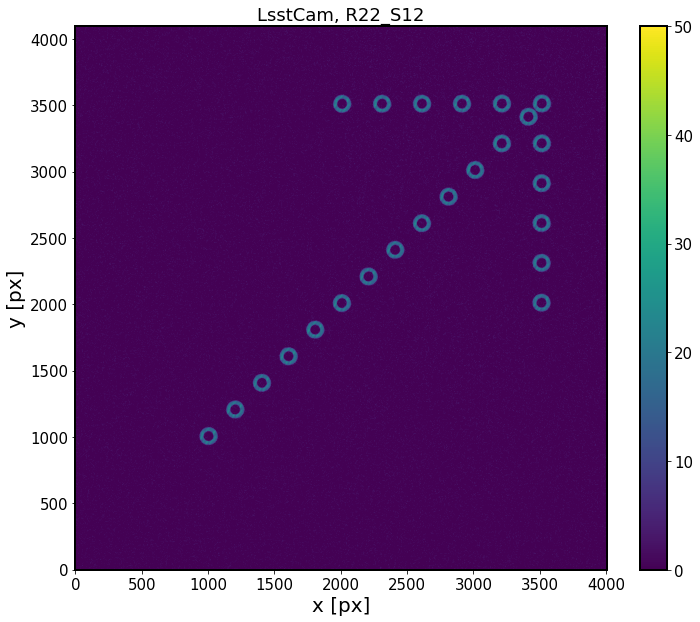

In [5]:
%matplotlib inline

exposure = butler.get('postISRCCD', dataId=datasetRefs[0].dataId, collections=['run1'])
detector = exposure.getDetector()
fig = plt.figure(figsize=(12, 10))
plt.imshow(exposure.image.array.T, origin='lower', vmin=0, vmax=50)
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title(f'LsstCam, {detector.getName()}')

# 2) lsstCam data (corner rafts)

Generate:
    
    cd /project/scichris/aos/images/cornerSensors/
        
    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/images/cornerSensors/starArrowsLetters.inst -i lsst -e 1 -c /project/scichris/aos/images/cornerSensors/noBkgnd.cmd -p 25 -o /project/scichris/aos/images/cornerSensors/arrowsLetters/raw/ > starPhoSim.log 2>&1

Repackage

    phosim_repackager.py /project/scichris/aos/images/cornerSensors/arrowsLetters/raw/ --out_dir /project/scichris/aos/images/cornerSensors/arrowsLetters/repackaged/

Ingest and ISR  lsstCam  corner raft data (I ingest only a  single raft for illustration):

    
    butler create DATA
    butler register-instrument DATA/ lsst.obs.lsst.LsstCam
    butler ingest-raws DATA /project/scichris/aos/images/cornerSensors/arrowsLetters/repackaged/

    butler define-visits DATA/ lsst.obs.lsst.LsstCam
    butler write-curated-calibrations DATA/ lsst.obs.lsst.LsstCam
    
Use this pipeline stored in `testPipeline.yaml` : 

    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          
Run the ISR task:

    pipetask run -j 9 -b DATA/ -i LSSTCam/raw/all,LSSTCam/calib -p testPipeline.yaml --register-dataset-types --output-run run1

Inspect the gen3 repository:

In [8]:
path_to_repo = '/project/scichris/aos/images/cornerSensors/arrowsLetters/DATA/'
butler = dafButler.Butler(path_to_repo)

registry = butler.registry
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)
    

for x in registry.queryCollections():
    print(x)
    
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())   

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('packages', {}, Packages)
LSSTCam/raw/all
LSSTCam/calib
LSSTCam/calib/unbounded
run1
{instrument: 'LSSTCam', detector: 199, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 200, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 203, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 195, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 204, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: '

Show the postISR image:

Text(0.5, 1.0, 'LsstCam, R44_SW1')

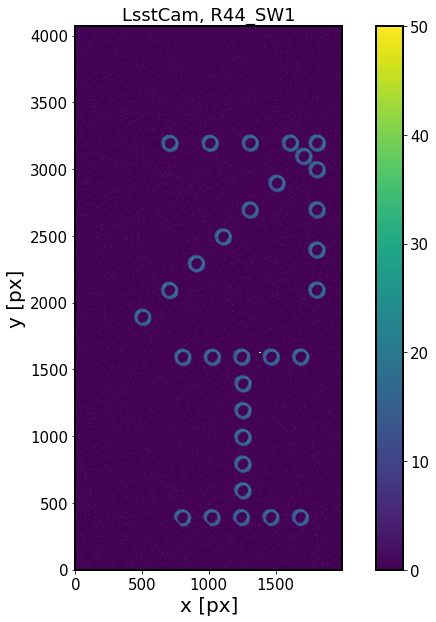

In [13]:
%matplotlib inline
exposure= butler.get('postISRCCD', dataId=datasetRefs[4].dataId, collections=['run1'])
detector = exposure.getDetector()
fig = plt.figure(figsize=(12, 10))
plt.imshow(exposure.image.array.T, origin='lower',vmin=0, vmax=50)
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title(f'LsstCam, {detector.getName()}')

# 3) comCam data (single  R22 ITL raft )

Generate data 

     python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/images/comCam/starExtra.inst -i comcam -e 1 -c /project/scichris/aos/images/comCam/noBkgnd.cmd -p 25 -o /project/scichris/aos/images/comCam/arrows/raw/ > starPhoSim.log 2>&1

Repackage

    phosim_repackager.py /project/scichris/aos/images/comCam/arrows/raw/ --out_dir /project/scichris/aos/images/comCam/arrows/repackaged/ --inst comcam


Ingest and ISR  comCam data:
    
    cd /project/scichris/aos/images/comCam/arrows/
    
    butler create DATA
    butler register-instrument DATA/ lsst.obs.lsst.LsstComCam
    butler ingest-raws DATA /project/scichris/aos/images/comCam/arrows/repackaged/

    butler define-visits DATA/ lsst.obs.lsst.LsstComCam
    butler write-curated-calibrations DATA/ lsst.obs.lsst.LsstComCam
    
Use this pipeline stored in `testPipeline.yaml` : 

    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.LsstComCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          
Run the ISR task:

    pipetask run -j 9 -b DATA/ -i LSSTComCam/raw/all,LSSTComCam/calib -p testPipeline.yaml --register-dataset-types --output-run run1

Show the posrISR image: 

In [14]:
path_to_repo = '/project/scichris/aos/images/comCam/arrows/DATA/'
butler = dafButler.Butler(path_to_repo)

registry = butler.registry
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)
    

for x in registry.queryCollections():
    print(x)
    
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())   

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('packages', {}, Packages)
LSSTComCam/raw/all
LSSTComCam/calib
LSSTComCam/calib/unbounded
run1
{instrument: 'LSSTComCam', detector: 5, exposure: 4000021706001, ...}
{instrument, detector, exposure}
{instrument: 'LSSTComCam', detector: 6, exposure: 4000021706001, ...}
{instrument, detector, exposure}
{instrument: 'LSSTComCam', detector: 0, exposure: 4000021706001, ...}
{instrument, detector, exposure}
{instrument: 'LSSTComCam', detector: 1, exposure: 4000021706001, ...}
{instrument, detector, exposure}
{instrument: 'LSSTComCam', detector: 8, exposure: 4000021706001, ...}
{instrument, detector, exposure}


Text(0.5, 1.0, 'LsstComCam, R22_S12 (ITL)')

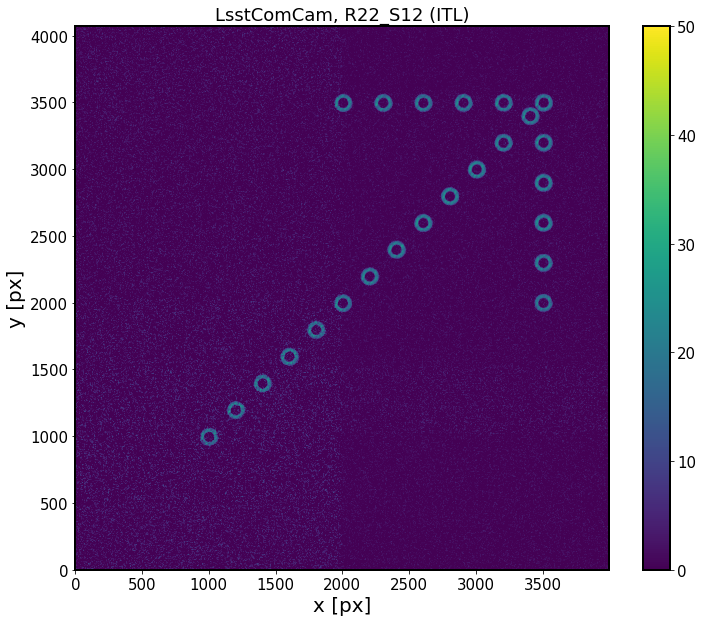

In [16]:
%matplotlib inline

exposure = butler.get('postISRCCD', dataId=datasetRefs[0].dataId, collections=['run1'])
detector = exposure.getDetector()
fig = plt.figure(figsize=(12, 10))
plt.imshow(exposure.image.array.T, origin='lower', vmin=0,vmax=50)
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title(f'LsstComCam, {detector.getName()} (ITL)')